In [44]:
%matplotlib inline

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import io
import codecs
from dateutil import parser
from janome.tokenizer import Tokenizer
from wordcloud import WordCloud
from collections import Counter, defaultdict
sns.set(color_codes=True)

# EDA

In [4]:
today = datetime.date.today()
until = str(today)

In [6]:
#YH_df = pd.read_csv("tweet/" + until + "/yawatahama_" + until + ".csv", sep = '\t', encoding='utf-16')
YH_df = pd.read_csv("tweet/2018-05-08/yawatahama_2018-05-08.csv", sep = '\t', encoding='utf-16')

In [9]:
print("num of tweet: ", YH_df.shape[0])

num of tweet:  1259


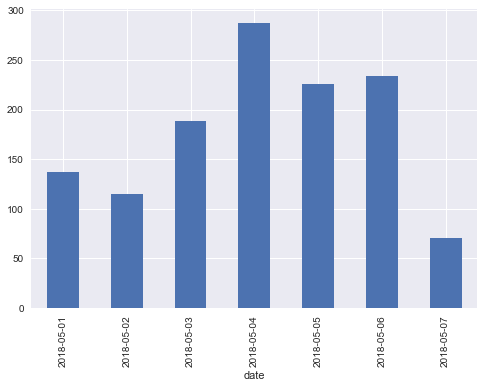

In [10]:
YH_df["date"] = pd.to_datetime(YH_df["created_at"], errors='coerce')
YH_df.groupby(YH_df["date"].dt.date).date.count().plot(kind="bar")

# WordCloud (only noun)

In [12]:
YH_df = YH_df[YH_df['text'].notnull()]

In [33]:
# janome 形態素分解
def janome_analysis(sentences, output):
    t = Tokenizer()
    words_count = defaultdict(int)
    words = []
    for sentence in sentences:
        tokens = t.tokenize(sentence)
        for token in tokens:
            # 品詞を取り出し
            partOfSpeech1 = token.part_of_speech.split(',')[0]
            partOfSpeech2 = token.part_of_speech.split(',')[1]
            
            if output == "normal":
                if partOfSpeech2 == '固有名詞' or partOfSpeech1 == '形容詞':
#                     if (token.base_form != ':' and 
#                         token.base_form != '@' and
#                         token.base_form != 'RT'):
    #                    token.base_form != '#' and 
    #                     token.base_form != '-' and
    #                     token.base_form != '/' and
    #                     token.base_form != '(' and
    #                     token.base_form != ')' and
    #                     token.base_form != '.'):
                    words_count[token.base_form] += 1
                    words.append(token.base_form)
            elif output == "cloud":
                if partOfSpeech1 == '名詞':

                    words_count[token.base_form] += 1
                    words.append(token.base_form)
    return words_count, words

In [16]:
texts = df_new['text'].str.replace('http\S+', '', case=False)
words_count, words = janome_analysis(texts, "cloud")
text = ' '.join(words)

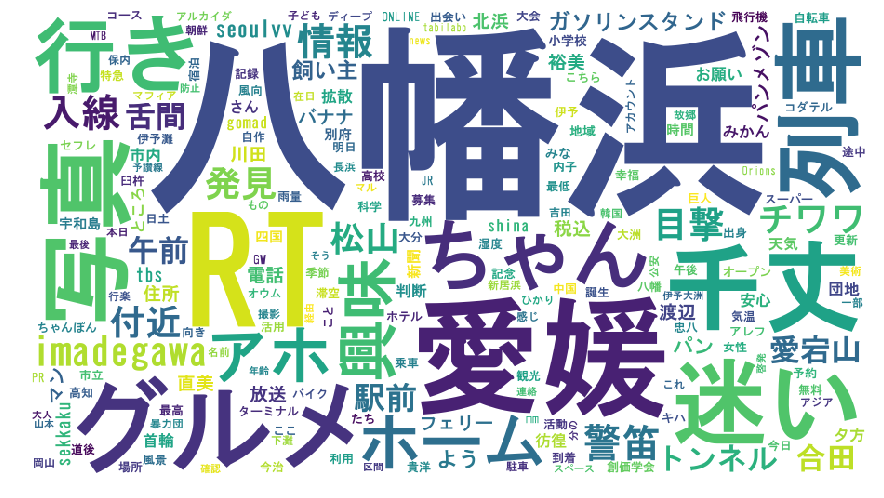

In [17]:
fpath = "C:\Windows\Fonts\HGRGE.TTC"
#word cloud
wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500, collocations=False).generate(text)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Explore frequent word (proper nouns and adjective)

In [19]:
YH_wo_rt = YH_df[YH_df['RT']==False]
YH_wo_rt = YH_wo_rt['text'].str.replace('http\S+', '', case=False)

In [34]:
words_count2, words2 = janome_analysis(YH_wo_rt, "normal")

In [35]:
Counter(words2).most_common()[:5]

[('八幡浜', 811), ('愛媛', 255), ('in', 66), ('松山', 58), ('I', 47)]

# Sentiment analysis

In [37]:
class CorpusElement:
    def __init__(self, text='', tokens=[], pn_scores=[]):
        self.text = text # テキスト本文
        self.tokens = tokens # 構文木解析されたトークンのリスト
        self.pn_scores = pn_scores # 感情極性値(後述)


# CorpusElementのリスト
naive_corpus = []

naive_tokenizer = Tokenizer()

for text in YH_wo_rt:
    tokens = naive_tokenizer.tokenize(text)
    element = CorpusElement(text, tokens)
    naive_corpus.append(element)

# 最初の1文章の形態素解析結果を表示
# for token in naive_corpus[0].tokens:
#     print(token)

In [38]:
# pn_ja.dicファイルから、単語をキー、極性値を値とする辞書を得る
def load_pn_dict():
    dic = {}
    
    with codecs.open('./pn_ja.dic', 'r', 'shift_jis') as f:
        lines = f.readlines()
        
        for line in lines:
            # 各行は"良い:よい:形容詞:0.999995"
            columns = line.split(':')
            dic[columns[0]] = float(columns[3])
            
    return dic

In [39]:
# トークンリストから極性値リストを得る
def get_pn_scores(tokens, pn_dic):
    scores = []
    
    for surface in [t.surface for t in tokens if t.part_of_speech.split(',')[0] in ['動詞','名詞', '形容詞', '副詞']]:
        if surface in pn_dic:
            scores.append(pn_dic[surface])
    
    if len(scores) == 0:
        scores.append(0)
    
    return scores

In [45]:
# 感情極性対応表のロード
pn_dic = load_pn_dict()

# 各文章の極性値リストを得る
for element in naive_corpus:
    element.pn_scores = get_pn_scores(element.tokens, pn_dic)

In [56]:
# 平均値が最も高い5件を表示
print('------------Show the 5 most postiive tweets------------------')
for element in sorted(naive_corpus, key=lambda e: sum(e.pn_scores)/len(e.pn_scores), reverse=True)[:5]:
    print('Average: {:.3f}'.format(sum(element.pn_scores)/len(element.pn_scores)))
    print('Title: {}'.format(io.StringIO(element.text).readline()))
    print('')


# 平均値が最も低い5件を表示
print('------------Show the 5 most negative tweets------------------')
for element in sorted(naive_corpus, key=lambda e: sum(e.pn_scores)/len(e.pn_scores))[:5]:
    print('Average: {:.3f}'.format(sum(element.pn_scores)/len(element.pn_scores)))
    print('Title: {}'.format(io.StringIO(element.text).readline()))
    print('')

#     for surface in [t.surface for t in element.tokens if t.part_of_speech.split(',')[0] in ['動詞','名詞', '形容詞', '副詞']]:
#         if surface in pn_dic:
#             print(surface)
    
#     print(element.pn_scores)
#     print('')

------------Show the 5 most postiive tweets------------------
Average: 0.988
Title: アメブロを更新しました。 『アゴラマルシェにBIGなお客様』 #八幡浜 #ミカフェート


Average: 0.986
Title: 八幡宿


Average: 0.969
Title: 明後日には八幡浜にいける！

Average: 0.964
Title: 八幡浜なら鯛よりも鯵を食べませう 

Average: 0.964
Title: 八幡浜なう


------------Show the 5 most negative tweets------------------
Average: -0.980
Title: 🚌待ち中


Average: -0.968
Title: GWは八幡浜も忙しい🙁


Average: -0.963
Title: 夜のフェリー乗り場って、なんかワクワクするよね　#八幡浜 

Average: -0.958
Title: 八幡浜は雨や☂️

Average: -0.951
Title: 相模原から17時間。八幡浜まで帰って来ました。 



# Check the most retweeted tweet

In [57]:
for i in range(5):
    print('num of retweet: ', YH_df['text'].value_counts().tolist()[i])
    print(YH_df['text'].value_counts().index.tolist()[i])
    print('')
    print('------------------------------------------------------------------')

num of retweet:  219
RT @imadegawa075: 八幡浜行き入線時にホームに足を下ろそうとしてたねーちゃんがまた警笛鳴らされてた。もうアホだろ。
ちなみに列車の写真を撮る人はほとんどいない。興味ないのがよく分かる。 https://t.co/CAbxyNqah4

------------------------------------------------------------------
num of retweet:  130
RT @seoulvv: 八幡浜市千丈にて黒のチワワ発見。数日前は愛宕山トンネル付近、合田、舌間、八代でも目撃されています。
迷い犬か、捨て犬か分かりませんが情報載せておきます。

5/3(木)午前8:50
八幡浜市千丈駅前のガソリンスタンドを歩いていました。

飼い主様が見つ…

------------------------------------------------------------------
num of retweet:  92
RT @sekkaku_tbs: 5月6日放送　せっかくグルメ④
【塩パン】77円（税込）
『パンメゾン』
住所：愛媛県八幡浜市北浜1-8-15
電話： 0894-27-0348
#せっかくグルメ　#せっかく　#グルメ　#バナナマン　#川田裕美  #渡辺直美  #愛媛県
#松山…

------------------------------------------------------------------
num of retweet:  53
RT @shina_gomad: 5/5夕方八幡浜八代団地内にて黒茶のチワワ？の迷い犬を発見。首輪は付けておりません。
数日前から付近を彷徨っており、市内至る所で目撃情報があるようです
迷い犬か捨て犬か判断つきかねますが、早く安心出来るところに帰れるよう拡散お願いいたします。…

------------------------------------------------------------------
num of retweet:  9
自作飛行機　ふわり空へ　八幡浜・忠八翁記念大会　488人が滞空時間競う愛媛新聞ONLINE

---------------------------------